# Calculations with cubic-scaling BigDFT code
In this tutorial we will show some basic calculations of some molecular systems performed with the traditional direct-minization algorithm of BigDFT code. We will base our examples on a system of water molecules.

Let's first start by copying the xyz file associated to the water molecules. We will use for this the XYZReader class:

In [1]:
!curl https://gitlab.com/max-centre/benchmarks/-/raw/master/BigDFT/H2O/CPU/posinp.xyz -o H2O-32.xyz 2> /dev/null

Be sure to set the user!

In [2]:
user = 'eugenovesel'

In [3]:
#if you are in a Google colab session
try:
    from google.colab import drive
    in_colab = True
except:
    in_colab = False
print('We are in a google colab session: ',in_colab)
if in_colab:
    import subprocess
    print(subprocess.check_output(['pip', 'install', '-U','pybigdft','pyfutile','py3Dmol','remotemanager']))


We are in a google colab session:  False


In [4]:
# this sets up some internal variables of the remotemanager plugin
import remotemanager
remotemanager.Logger.level = 'debug'
remotemanager.Logger.path = 'H2O-vega'

After some session setup, let's start by defining the System:

In [5]:
from BigDFT.IO import XYZReader
from BigDFT.Systems import System
from BigDFT.Fragments import Fragment

sys = System()
with XYZReader("H2O-32.xyz") as ifile:
    for iat, atom in enumerate(ifile):
        if iat % 3 == 0:
            frag = Fragment()
            sys['HOH:'+str(int(iat/3)+1)] = frag
        frag.append(atom)
    sys.cell=ifile.cell

In [6]:
sys.display()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

# Single water molecule calculation
Let us now start by a simple example of one single water molecule. We take as reference a system made by one of the molecues of the total assembly

In [7]:
choice='HOH:16'
H2O = System({choice:sys[choice]})
H2O.display()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

We save this system in a xyz file for future reuse.

In [8]:
from BigDFT.IO import write_xyz
with open('H2O-1.xyz','w') as ofile:
    write_xyz(system=H2O,ofile=ofile)

## Remote calculation of a dataset of different runs of the water molecule
We would like to employ the remote machine to run different calculations of the water molecule. We will perform single point calculations with:

LDA functional, in gas phase
PBE functional, in gas phase
PBE functional, in implicit solvent
PBE0 functional, in gas phase (with CPU only)
Let us now construct the remote function we would like to use for the calculations. Such function employs some of the functionalities of the BigDFT code and the role of each line is documented. Of course this serves only as an overview of the BigDFT functionalities. We encourage to have a look at the other tutorials of the code to inspect more the way in which such functionalities can be tuned.

In [9]:
def calculate_single_point(run_name, filename, functional, solvent=False, run_directory='Calculations', gpu=False):
    from BigDFT import Calculators as C, Inputfiles as I
    from futile.Utils import create_tarball
    from os.path import join
    # create a reasonable set of input parameters for the molecule
    inp = I.Inputfile()
    # self-explanatory line
    inp.set_xc(functional)
    # grid spacing (like a plane-wave cutoff, the lower the more precise)
    inp.set_hgrid(0.4)
    # Get the pseudpotential files
    inp.set_psp_nlcc()
    # include soft-sphere implicit model if required
    if solvent:
        inp.set_implicit_solvent(solvent='water',minres=1.0e-8)
    if gpu:
        inp.setdefault('psolver',{}).setdefault('setup',{}).update({'accel': 'CUDA'})
    # create the calculator
    code = C.SystemCalculator(skip=True)
    # launch the calculation and retrieve the logfile instance
    log = code.run(input=inp, name=run_name, posinp=filename, run_dir=run_directory)
    # we create a tarfile that contains the logfile as well as the information about the timing
    create_tarball(run_name+'.tar.gz',files=[join(run_directory,'log-'+run_name+'.yaml'),
                                             join(run_directory,'time-'+run_name+'.yaml')])
    # return the energy
    return log.energy

Such function can be executed locally (we encourage you to do so in a workstation where bigdft-suite is installed). Here, we create a dataset of such remote functions to execute the pool of jobs into Vega, from this notebook.



In [10]:
from remotemanager import Dataset
from remotemanager.connection.computers import Vega

As per the remotemanager tutorial, we set up the information about the vega setup.
It is important also to set the information about the gpu script.
Such information can be provided in a configuration file that is associate to the computer.

In [11]:
import yaml
# vega yaml specification:
vega_spec=yaml.load("""
modules:
    - SciPy-bundle/2022.05-intel-2022a
    - CMake/3.23.1-GCCcore-11.3.0
    - Meson/0.62.1-GCCcore-11.3.0

modules_gpu:
    - SciPy-bundle/2020.03-foss-2020a-Python-3.8.2
    - fosscuda
    - MKL
    - CMake/3.18.4-GCCcore-10.2.0
    - Meson/0.55.3-GCCcore-10.2.0
    - GSL/2.6-GCC-10.2.0
    - Doxygen/1.8.20-GCCcore-10.2.0
    
extra: |
    export PREFIX=/ceph/hpc/data/d2021-135-users/softwares/BigDFT/binaries/install
    source $PREFIX/bin/bigdftvars.sh
    export OMPI_MCA_orte_base_help_aggregate=0
    export BIGDFT_MPIRUN=mpirun
    export FUTILE_PROFILING_DEPTH=0
    export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK

extra_gpu: |
    export PREFIX=/ceph/hpc/data/d2021-135-users/softwares/BigDFT/binaries-cuda/install
    source $PREFIX/bin/bigdftvars.sh
    export OMPI_MCA_orte_base_help_aggregate=0
    export BIGDFT_MPIRUN=mpirun
    export FUTILE_PROFILING_DEPTH=0
    export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK
""", Loader=yaml.Loader)
    

In [12]:
url = Vega(host='vega')
for attribute, value in vega_spec.items():
    setattr(url, attribute, value)

In [13]:
from os.path import join, relpath
from BigDFT.RemoteRunners import computer_runner, RemoteDataset
local_dir = 'H2O-single'
remote_dir = f'/ceph/hpc/data/d2021-135-users/bigdft-school/{user}/H2O-single' #use your own directory for new calculations
force_reinitialization = True # in case you rerun this cell multiple times
filename = 'H2O-1.xyz'
all_runs = Dataset(function = calculate_single_point,
                   url = url,
                   name = 'H2O-single',
                   remote_dir = remote_dir,
                   local_dir = local_dir,
                   extra_files_send=filename,
                   block_reinit = force_reinitialization)

#we collect the run names for future reuse
run_names = []
# the we append the runs we would like to perform
for functional, solvent in [('LDA', False), ('PBE', False), ('PBE', True), ('PBE0', False)]:
    #identify a name for the run
    run_name = '-'.join([filename.split('.')[0],functional] + (['PCM'] if solvent else []))
    # we then have the arguments of the function to submit
    func_kwargs = dict(run_name=run_name, filename=filename, functional=functional, solvent=solvent)
    # we decide to execute such calculations with cpu, 4 MPI and 4 OMP threads
    run_args = {}
    run_args['jobname'] = run_name
    run_args['mpi'] = 4
    run_args['omp'] = 4
    run_args['time'] = 2 # minutes
    
    all_runs.append_run(args=func_kwargs, 
                        extra_files_recv=[run_name+'.tar.gz'],
                        **run_args)
    run_names.append(run_name)


In [14]:
#for slow connections
all_runs.url.timeout=120
all_runs.url.max_timeouts=20
all_runs.url.raise_errors=False

In [15]:
all_runs.run()

In [22]:
all_runs.run_cmds

The jobs are now submitted on vega. In case you would like to verify, log in on the machine and verify the squeue command.

In [23]:
#you can also run this:
all_runs.url.raise_errors=False
all_runs.url.cmd('squeue --me')

JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)

In [18]:
print(all_runs.is_finished)

[True, True, True, True]


In [26]:
all_runs.url.raise_errors=False
all_runs.fetch_results()

There are 1 errors, printing:
stderr from run call:
Failed to add the ECDSA host key for IP address '153.5.68.45' to the list of known hosts (/home/genovese/.ssh/known_hosts).


RuntimeError: There was an issue during running. See printed info or logfile at ./H2O-vega.yaml

In [ ]:
energies = all_runs.results

In [ ]:
energies

# Analysis of the runs
After those runs have been executed we can compare different quantities among the various runs, for illustrative purposes. We will highlight:

1. The Density of States
2. The Molecule dipole
3. The profiling of the different timing categories

We start by unpacking the received data

In [28]:
def extract_results(directory):
    from futile.Utils import file_list
    import tarfile
    from os.path import join
    for archive in file_list(directory,suffix='.tar.gz',exclude='files',include_directory_path=True):
        arch = tarfile.open(archive)
        arch.extractall(path=directory)
        arch.close()

In [29]:
# the data are unpacked in a "Calculations" subdirectory (see above arguments)
extract_results('H2O-single')

In [30]:
#patch the yaml files from a mistake in the case of low profiling depth
!sed -i s/^\ *\:\ null/\ \ \ \ null/g H2O-single/Calculations/time*

In [31]:
from BigDFT.Logfiles import Logfile as L
logs = {name.lstrip('H2O-1-'): L(join('H2O-single','Calculations','log-'+name+'.yaml'))
        for name in run_names}

## Density of States

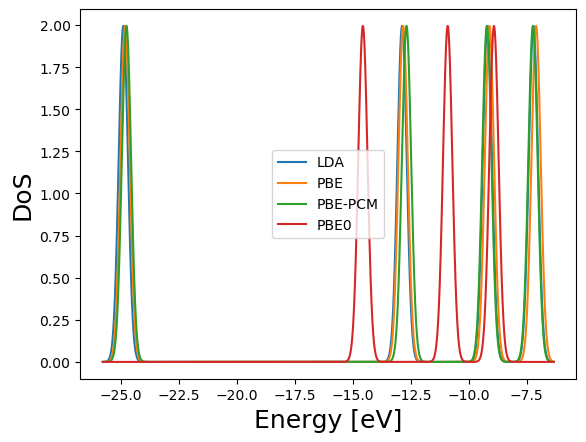

In [32]:
from BigDFT.DoS import DoS
dos = DoS(logfiles_dict=logs)
dos.plot().legend(loc='best')

Where we see the localization effect of the Hybrid functional with respect to the energies of the semilocal ones.

## Total Dipole
We do a pretty printing via dataframes, just for fun. This is optional of course.

In [33]:
def dipole_info(log):
    data = {coord+ ' (AU)': log.dipole[i] for i, coord in enumerate(['x', 'y', 'z'])}
    data['Norm (Debye)'] = log.log['Electric Dipole Moment (Debye)']['norm(P)']
    return data

In [34]:
from pandas import DataFrame
data = {name: dipole_info(log)for name, log in logs.items()}
table = DataFrame(data).T
table.round(2)

,x (AU),y (AU),z (AU),Norm (Debye)
LDA,0.59,0.34,-0.19,1.81
PBE,0.59,0.34,-0.19,1.78
PBE-PCM,0.76,0.44,-0.24,2.30
PBE0,0.61,0.35,-0.19,1.84


Here we see the polarizability effect induced by the environment.

## Time to solution
We can also inspect the different timings for this runs, to understand how the computational resources have been used in the different approximations

In [35]:
times = {name: join('H2O-single','Calculations','time-'+name+'.yaml')
        for name in run_names}

In [36]:
def plot_timings(times):
    from futile.Time import TimeData
    from matplotlib import pyplot as plt
    tt=TimeData(*times.values(),static=True,plottype='Seconds')
    #tweak the name of the labels
    fig=plt.gcf()
    ax=fig.get_axes()
    _=ax[0].set_xticklabels(run_names,rotation=90)#,size=self.fontsize)

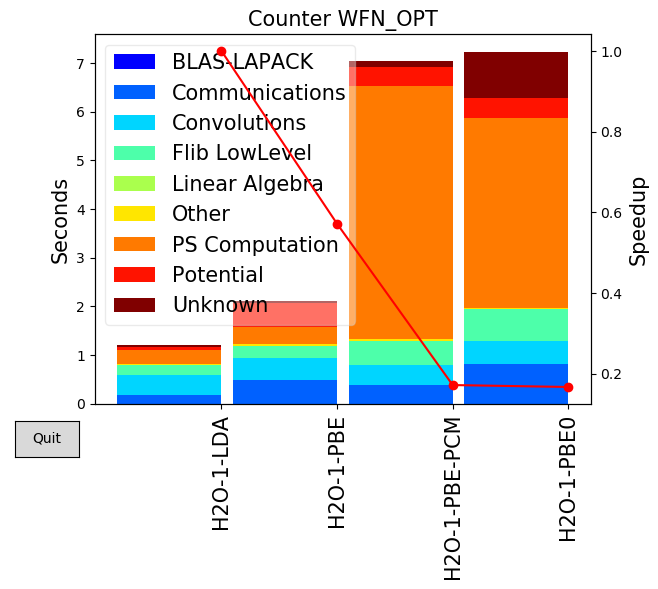

In [37]:
plot_timings(times)

We see that the PCM computation and the PBE0 calcuations take the same amount of time for the SCF cycle. Those data are only partially considering the time for the entire run which also takes into account the initialisation and the finalization



In [38]:
def get_total_time_info(time):
    import yaml
    with open(time) as ifile:
        dt = yaml.load(ifile,Loader=yaml.Loader)
    data = {k: v[1] for k, v in dt['SUMMARY'].items()}
    data.update({'WFN_OPT %': dt['SUMMARY']['WFN_OPT'][0]})
    return data

In [39]:
table=DataFrame({name:get_total_time_info(time) for name, time in times.items()}).T
table.round(3)

,INIT,WFN_OPT,LAST,Total,WFN_OPT %
H2O-1-LDA,2.6,1.2,0.21,4.0,30.2
H2O-1-PBE,2.6,2.1,0.30,5.0,41.9
H2O-1-PBE-PCM,2.9,7.0,0.85,11.0,65.2
H2O-1-PBE0,3.5,7.2,0.91,12.0,61.9


# GPU acceleration
We have the possiblity of accelerating the computation using GPU. We start by performing a rather insignificant accelration on a single molecule, and then we will move to the larger 32 H2O system. Let's increment our dataset:

In [40]:
#identify a name for the run
run_name = 'H2O1-PBE0-GPU'
# we then have the arguments of the function to submit
func_kwargs = dict(run_name=run_name, filename=filename, functional='PBE0')

run_args = {}
run_args['gpu'] = True  # enable GPU
run_args['jobname'] = run_name
run_args['mpi'] = 1
run_args['omp'] = 4
run_args['time'] = 2
    
all_runs.append_run(args=func_kwargs, 
                    extra_files_send=filename,
                    extra_files_recv=run_name+'.tar.gz',
                    **run_args)

In [41]:
all_runs.run()

already submitted, skipping
already submitted, skipping
already submitted, skipping
already submitted, skipping


In [48]:
all_runs.run_cmds

[Submitted batch job 50397405]

In [43]:
all_runs.results

[None, None, None, None, None]

**Exercise**: perform the same analysis as above to verify what has changed.

# Run of the full system
We will now crate a dataset of larger runs with the system identified from the full molecule. We will run the calculation with:

PBE, CPU only
PBE0, CPU only
PBE0, GPU accelerated
We will employ one single node of the VEGA architecture, knowing that the two architectures are different

In [45]:
local_dir = 'H2O-many'
remote_dir = f'/ceph/hpc/data/d2021-135-users/bigdft-school/{user}/H2O-many' #use your own directory for new calculations

filename = 'H2O-32.xyz'

large_runs = Dataset(function = calculate_single_point,
                     url = url,
                     name = 'H2O-many',
                     extra_files_send=filename,                     
                     remote_dir = remote_dir,
                     local_dir = local_dir,
                     block_reinit = force_reinitialization)


#we collect the run names for future reuse
large_run_names = []
# the we append the runs we would like to perform
for functional, gpu in [('PBE', False), ('PBE0', False), ('PBE0', True)]:
    #identify a name for the run
    run_name = '-'.join([filename.split('.')[0],functional] + (['GPU'] if gpu else []))
    # we then have the arguments of the function to submit
    func_kwargs = dict(run_name=run_name, filename=filename, functional=functional, gpu=gpu)
    # the full system has 128 KS orbitals
    run_args = {}
    run_args['jobname'] = run_name
    run_args['mpi'] = 32 if gpu else 128
    run_args['omp'] = 4 if gpu else 2 # the cpu node has 256 cores
    run_args['time'] = '00:10:00'
    run_args['gpu'] = gpu
    
    large_runs.append_run(args=func_kwargs, 
                          extra_files_recv=[run_name+'.tar.gz'],
                          **run_args)
    large_run_names.append(run_name)

In [48]:
large_runs.url.ssh='ssh 2>/dev/null'

In [49]:
large_runs.run()

already submitted, skipping
already submitted, skipping
already submitted, skipping


In [50]:
large_runs.run_cmds

[]

In [50]:
large_runs.fetch_results()

In [51]:
large_energies = large_runs.results

In [52]:
large_energies

[-564.0227610700186, -555.2397578478464, None]

In [ ]:
extract_results('H2O-many')
!sed -i s/^\ *\:\ null/\ \ \ \ null/g H2O-many/Calculations/time*

In [ ]:
large_logs = {name.lstrip('H2O-32'): L(join('H2O-many','Calculations','log-'+name+'.yaml'))
              for name in reversed(large_run_names)}

In [ ]:
large_dos = DoS(logfiles_dict=large_logs)
large_dos.plot().legend(loc='best')

In [ ]:
reordered = [large_run_names[i] for i in [1,2,0]]
large_times = {name: join('H2O-many','Calculations','time-'+name+'.yaml')
               for name in reordered}
tt=TimeData(*large_times.values(),static=True,plottype='Seconds')
#tweak the name of the labels
fig=plt.gcf()
ax=fig.get_axes()
_=ax[0].set_xticklabels(reordered,rotation=90)

We see that with the usage of one single node, we get similar timings between the GPU-accelerated PBE0 and the traditionale PBE calculation on a GPU architecture